# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


import numpy as np 
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import sys
import os
import re
import string
from sqlalchemy import create_engine
import pickle

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator,TransformerMixin

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# load data from database
engine = create_engine('sqlite:///DB_Disasters.db')
df = pd.read_sql_table('T_Categorized_Messages', engine)

df.head()
 

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
PctByCat=df.iloc[:, 4:].sum()/df.shape[0]
PctByCat=pd.DataFrame(a).sort_values(by=[0])
PctByCat.head()

,0
child_alone,0.000000
offer,0.004501
shops,0.004578
tools,0.006065
fire,0.010757


[]

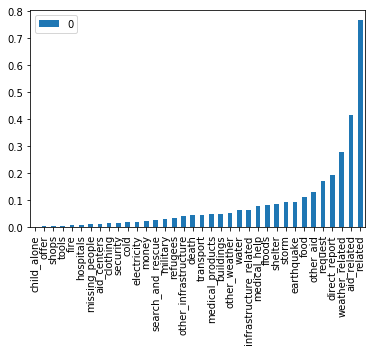

In [14]:
ax=PctByCat.plot.bar(y=[0])
ax.plot()

Let's eliminate child_alone bcause has only 0

Lets clean the response to binary 

In [15]:
# Remove child alone, column of 0's
df = df.drop(['child_alone'], axis = 1)

In [16]:
X = df['message']
y = df.iloc[:, 4:]


### 2. Write a tokenization function to process your text data

In [15]:
def tokenize(text):
    '''
    
    '''

    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 

    # Extract the word tokens from the provided text
    words = word_tokenize(text)

    # Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]

    # Lemmatization
    lemmed = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    return lemmed

## Test the function

In [16]:
text = X[10]
clean_tokens=tokenize(text)
print (clean_tokens)

print(text)


['nothing', 'eat', 'water', 'starving', 'thirsty']
There's nothing to eat and water, we starving and thirsty.


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [17]:
pipeline = Pipeline(
    [
        (
            "features",
            FeatureUnion(
                [
                    (
                        "text_pipeline",
                        Pipeline(
                            [
                                (
                                    "count_vectorizer",
                                    CountVectorizer(tokenizer=tokenize),
                                ),
                                ("tfidf_transformer", TfidfTransformer()),
                            ]
                        ),
                    ),
                ]
            ),
        ),
        ("classifier", MultiOutputClassifier(RandomForestClassifier())),
    ]
)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline_fitted = pipeline.fit(X_train, y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [19]:
y_prediction_train = pipeline_fitted.predict(X_train)
y_prediction_test = pipeline_fitted.predict(X_test)

In [20]:
print(classification_report(y_test.values, y_prediction_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               request       0.78      0.43      0.56      1151
                 offer       0.00      0.00      0.00        33
           aid_related       0.73      0.59      0.65      2785
          medical_help       0.65      0.10      0.18       533
      medical_products       0.66      0.12      0.21       335
     search_and_rescue       0.85      0.09      0.16       199
              security       0.00      0.00      0.00       129
              military       0.79      0.06      0.12       239
           child_alone       0.00      0.00      0.00         0
                 water       0.84      0.34      0.49       431
                  food       0.90      0.45      0.60       753
               shelter       0.79      0.33      0.47       593
              clothing       0.82      0.09      0.16       105
                 money       0.60      0.06      0.10       162
        missing_people       0.50      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [27]:
parameters = {
        'classifier__estimator__max_depth': [ 20, 40, 60],
        'classifier__estimator__n_estimators': [5, 10, 15]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [28]:
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__estimator__max_depth': [20, 40, 60], 'classifier__estimator__n_estimators': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
y_prediction_test = cv.predict(X_test)
y_prediction_train = cv.predict(X_train)

In [30]:
print(classification_report(y_test.values, y_prediction_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               request       1.00      0.01      0.03      1151
                 offer       0.00      0.00      0.00        33
           aid_related       0.86      0.25      0.39      2785
          medical_help       1.00      0.00      0.01       533
      medical_products       1.00      0.01      0.01       335
     search_and_rescue       0.00      0.00      0.00       199
              security       0.00      0.00      0.00       129
              military       0.00      0.00      0.00       239
           child_alone       0.00      0.00      0.00         0
                 water       1.00      0.00      0.00       431
                  food       1.00      0.01      0.03       753
               shelter       0.00      0.00      0.00       593
              clothing       0.00      0.00      0.00       105
                 money       0.00      0.00      0.00       162
        missing_people       0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [31]:
cv.best_params_

{'classifier__estimator__max_depth': 20,
 'classifier__estimator__n_estimators': 15}

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [32]:
model = pickle.dumps('classifier.pkl')

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.